In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import  Dense, Dropout # type: ignore
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore 
from scikeras.wrappers import KerasRegressor

In [4]:
data = pd.read_parquet("../../Data/preprocessed/train_data_after_FE.parquet")

In [5]:
data.head()

,Store,Date,DayOfWeek,CompetitionDistance,CompetitionDistanceMissing,CompetitionOpenMissing,SchoolHoliday,Promo,Promo2,StoreType,...,Month_cos,IsWeekend,IsMonthEnd,IsMonthStart,OpenDuration,Promo2WeeksDuration,IsPromo2Month,DaysUntilNextStateHoliday,DaysSinceLastStateHoliday,DaysUntilClosed
Date_index,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,2013-01-02,3,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-03,1,2013-01-03,4,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-04,1,2013-01-04,5,1270.0,False,False,1,False,False,c,...,0.866025,False,False,False,24,0,False,14,14,7
2013-01-05,1,2013-01-05,6,1270.0,False,False,1,False,False,c,...,0.866025,True,False,False,24,0,False,14,14,7
2013-01-07,1,2013-01-07,1,1270.0,False,False,1,True,False,c,...,0.866025,False,False,False,24,0,False,14,14,7


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 2013-01-02 to 2015-07-31
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Store                       844338 non-null  int16         
 1   Date                        844338 non-null  datetime64[ns]
 2   DayOfWeek                   844338 non-null  int8          
 3   CompetitionDistance         842152 non-null  float32       
 4   CompetitionDistanceMissing  844338 non-null  bool          
 5   CompetitionOpenMissing      844338 non-null  bool          
 6   SchoolHoliday               844338 non-null  int8          
 7   Promo                       844338 non-null  bool          
 8   Promo2                      844338 non-null  bool          
 9   StoreType                   844338 non-null  category      
 10  Assortment                  844338 non-null  category      
 11  Sales                       844

In [7]:
data = data.drop(columns="Date")

In [8]:
standard_scale_features = [
    "CompetitionDistance",
    "OpenDuration",
    "Promo2WeeksDuration",
    "DaysUntilNextStateHoliday",
    "DaysSinceLastStateHoliday",
    "DaysUntilClosed",
    "SchoolHoliday",
    "Promo",
    "Promo2",
    "IsPromo2Month",
    "Year",
    "Month",
    "Day",
    "DayOfYear",
    "WeekOfYear",
    "Store",
    "DayOfWeek",
]

minmax_scale_features = ["DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos"]

boolean_features = [
    "CompetitionDistanceMissing",
    "CompetitionOpenMissing",
    "IsLastDayOfMonth",
    "IsWeekend",
    "IsMonthEnd",
    "IsMonthStart",
]

categorical_features_ohe = ["StoreType", "Assortment"]

numerical_features = standard_scale_features + boolean_features

In [9]:
standard_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
minmax_pipe = Pipeline(
    [("scaler", MinMaxScaler())]
)
cat_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("std_num", standard_pipe, numerical_features),
        ("minmax_cyc", minmax_pipe, minmax_scale_features),
        ("cat_ohe", cat_pipe, categorical_features_ohe),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [10]:
data.index = pd.to_datetime(data.index)
max_date = data.index.max()
split_date = max_date - pd.Timedelta(days=42)

train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()


X_train = train.drop(columns="Sales")
y_train = train.Sales
x_test = test.drop(columns="Sales")
y_test = test.Sales

print(X_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(804056, 29)
(804056,)
(40282, 29)
(40282,)


In [11]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(x_test)

In [12]:
np.random.seed(42)
model_baseline = Sequential()
model_baseline.add(
    Dense(units=512, activation="relu", input_shape=(X_train_scaled.shape[1],)))
model_baseline.add(Dense(units=256, activation="relu"))
model_baseline.add(Dense(units=128, activation="relu"))
model_baseline.add(Dense(units=1))

model_baseline.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

model_baseline.summary()

print("\n--- Model Training ---")
history_baseline = model_baseline.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    verbose=1,
)

# 6. Model Evaluation
print("\n--- Baseline Evaluation ---")
loss_base, mae_base = model_baseline.evaluate(
    X_test_scaled, y_test, verbose=0
)
print(f"BASE Model Results on Test Set:")
print(f"Loss (MSE): {loss_base:.4f}")
print(f"MAE: {mae_base:.4f}")

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,273 (712.00 KB)

 Trainable params: 182,273 (712.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Model Training ---
Epoch 1/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.2019 - mae: 0.2972 - val_loss: 0.1069 - val_mae: 0.2527
Epoch 2/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 0.1047 - mae: 0.2503 - val_loss: 0.0944 - val_mae: 0.2350
Epoch 3/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.0851 - mae: 0.2234 - val_loss: 0.0843 - val_mae: 0.2222
Epoch 4/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 0.0711 - mae: 0.2021 - val_loss: 0.0786 - val_mae: 0.2158
Epoch 5/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - loss: 0.0619 - mae: 0.1867 - val_loss: 0.0819 - val_mae: 0.2209
Epoch 6/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0556 - mae: 0.1760 - val_loss: 0.0624 - val_mae: 0.1888
Epoch 7/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0507 - mae: 0.1672 - val_loss: 0.0634 - val_mae: 0.1902
Epoch 8/20
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 0.0468 - mae: 0.1602 - val_loss: 0.0590 - val_mae: 0.1834
Epoch 9/

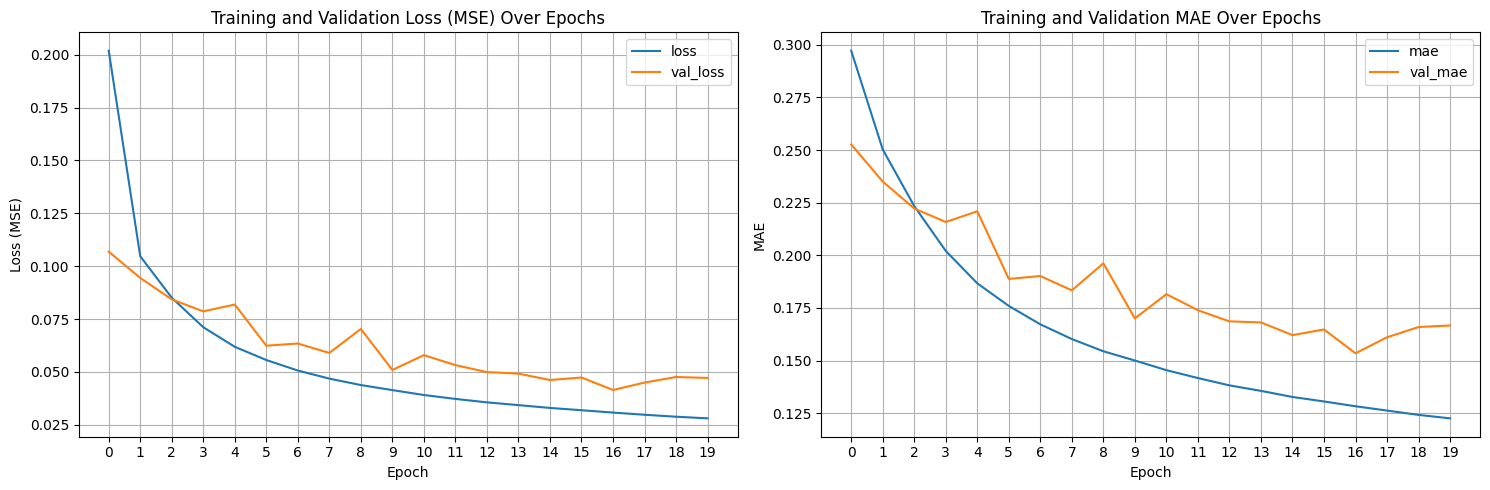

In [13]:
history_df = pd.DataFrame(history_baseline.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

history_df[["loss", "val_loss"]].plot(
    ax=axes[0],
    title="Training and Validation Loss (MSE) Over Epochs",
    xlabel="Epoch",
    ylabel="Loss (MSE)",
)
axes[0].grid(True)
axes[0].set_xticks(history_df.index)

history_df[["mae", "val_mae"]].plot(
    ax=axes[1],
    title="Training and Validation MAE Over Epochs",
    xlabel="Epoch",
    ylabel="MAE",
)
axes[1].grid(True)
axes[1].set_xticks(history_df.index)

plt.tight_layout()
plt.show()

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


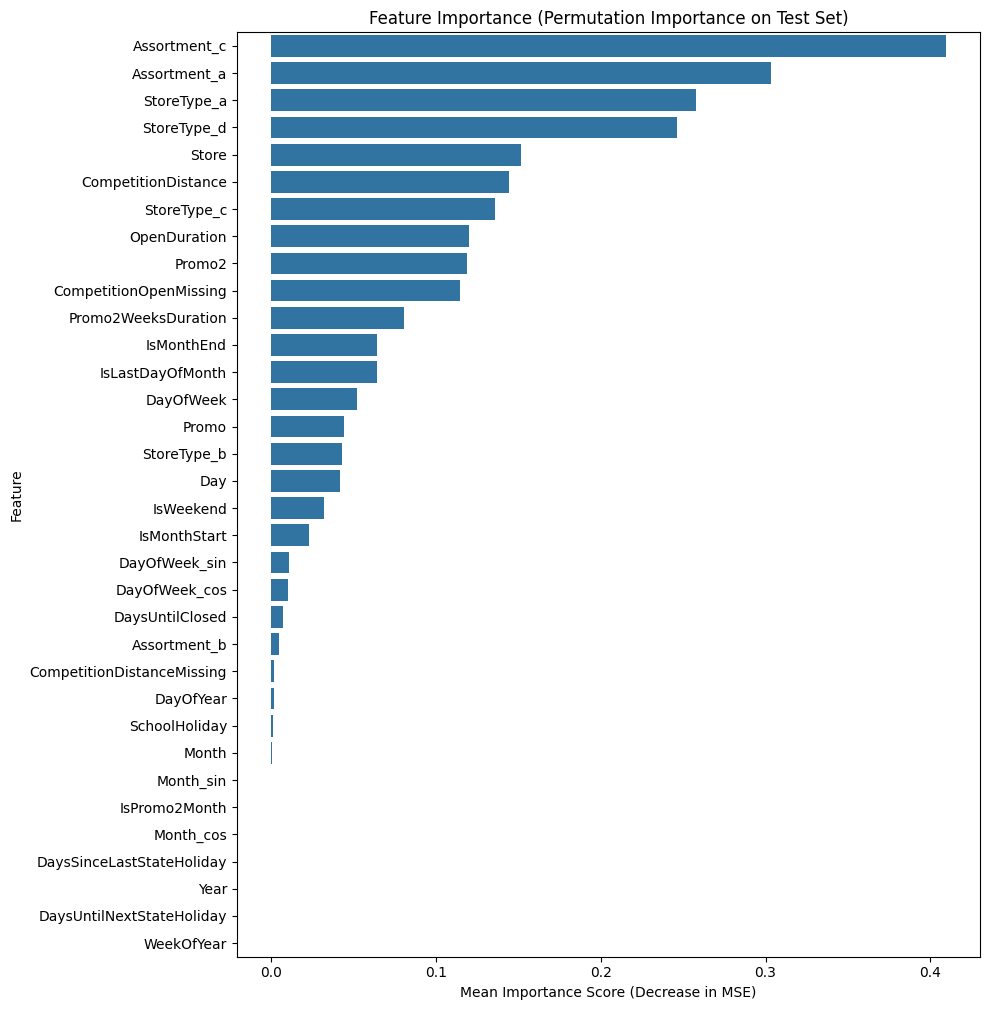

In [15]:
feature_names = preprocessor.get_feature_names_out()

r_perm = permutation_importance(
    estimator=model_baseline,
    X=X_test_scaled,
    y=y_test,
    scoring=lambda estimator, X, y: -mean_squared_error(
        y, estimator.predict(X).flatten()
    ),
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)
importance_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance_Mean": r_perm.importances_mean,
        "Importance_Std": r_perm.importances_std,
    }
).sort_values(by="Importance_Mean", ascending=False)

plt.figure(figsize=(10, len(importance_df) * 0.3))
sns.barplot(
    x="Importance_Mean",
    y="Feature",
    data=importance_df,
    capsize=0.2,
)
plt.title("Feature Importance (Permutation Importance on Test Set)")
plt.xlabel("Mean Importance Score (Decrease in MSE)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [16]:
y_predict_log = model_baseline.predict(X_test_scaled)
y_predict_flat = y_predict_log.flatten()

r2 = r2_score(y_test, y_predict_flat)

mse_sk = mean_squared_error(y_test, y_predict_flat)

print(f"\n--- Extended Evaluation (Scikit-learn) ---")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse_sk:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_sk):.4f}")

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

--- Extended Evaluation (Scikit-learn) ---
R-squared (R2): 0.7277
Mean Squared Error (MSE): 0.0472
Root Mean Squared Error (RMSE): 0.2172


In [17]:
y_predicted = np.expm1(y_predict_flat)
y_test_original = np.expm1(y_test)

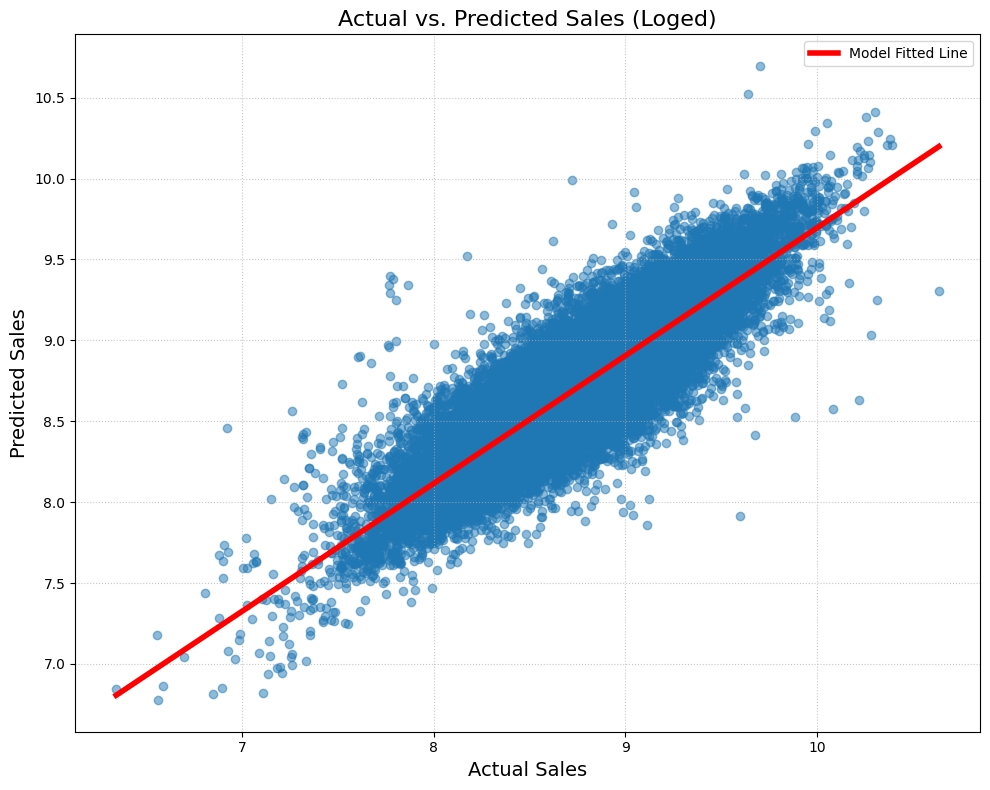

In [26]:
comparison_df = pd.DataFrame(
    {
        "Actual_Sales": y_test,
        "Predicted_Sales": y_predict_flat,
    }
)

plt.figure(figsize=(10, 8))

sns.regplot(
    x=y_test,
    y=y_predict_flat,
    scatter_kws={
        "alpha": 0.5,
    },
    line_kws={"color": "red", "label": "Model Fitted Line", "linewidth": 4},
)

plt.xlabel("Actual Sales", fontsize=14)
plt.ylabel("Predicted Sales", fontsize=14)
plt.title("Actual vs. Predicted Sales (Loged)", fontsize=16)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

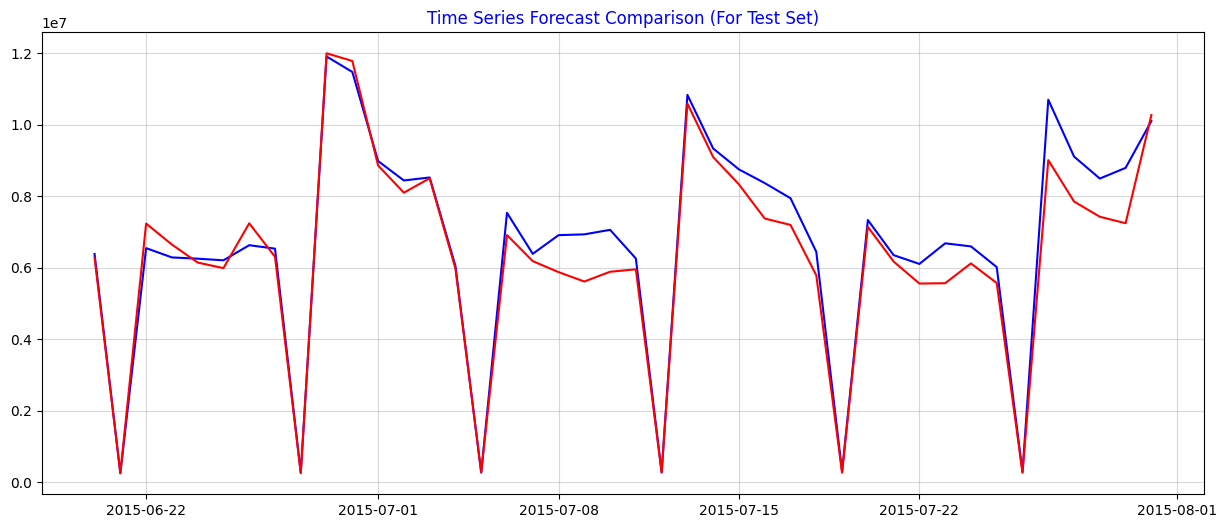

In [20]:
results_df = pd.DataFrame(
    {
        "Date": y_test_original.index,
        "Store": x_test.Store,
        "Actual_Sales": y_test_original,
        "Predicted_Sales": y_predicted,
    }
).set_index("Date")
df_aggregate = results_df.groupby(results_df.index).agg(
    {"Actual_Sales": "sum", "Predicted_Sales": "sum"}
)
plt.figure(figsize=(15, 6))

plt.plot(
    df_aggregate.index,
    df_aggregate["Actual_Sales"],
    label="Total Actual Daily Sales",
    color="blue",
)
plt.plot(
    df_aggregate.index,
    df_aggregate["Predicted_Sales"],
    label="Total Predicted Daily Sales",
    color="red",
)
plt.title("Time Series Forecast Comparison (For Test Set)", c="blue")
plt.grid(True, alpha=0.5)
plt.show()

# Model after enhancements

In [38]:
import keras_tuner as kt 

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2, min_lr=0.00001, verbose=1
)


def build_model(hp):
    model = Sequential()
    hp_units_1 = hp.Choice("units_1", values=[256, 512])
    model.add(
        Dense(
            hp_units_1,
            activation="relu",
            kernel_initializer=hp.Choice(
                "weight_init", values=["he_uniform", "glorot_uniform"]
            ),
            input_shape=(X_train_scaled.shape[1],),
        )
    )

    hp_dropout = hp.Choice("dropout_rate", values=[0.1, 0.2, 0.3])
    model.add(Dropout(hp_dropout))

    hp_units_2 = hp.Choice("units_2", values=[128, 256])
    model.add(Dense(hp_units_2, activation="relu"))
    model.add(Dropout(hp_dropout))

    model.add(Dense(128, activation="relu"))

    model.add(Dense(1))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001, 0.0005])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mse", "mae"])
    return model


tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="keras_tuner_dir",
    project_name="rossmann_sales",
    seed=42,
)

print("Starting Hyperparameter Search...")
print(tuner.search_space_summary())

tuner.search(
    X_train_scaled,
    y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest Hyperparameters:")
print(f"  units_1: {best_hps.get('units_1')}")
print(f"  units_2: {best_hps.get('units_2')}")
print(f"  dropout_rate: {best_hps.get('dropout_rate')}")
print(f"  learning_rate: {best_hps.get('learning_rate')}")
print(f"  weight_init: {best_hps.get('weight_init')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Add checkpoint callback
checkpoint = ModelCheckpoint(
    "best_rossmann_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
)

print("\nTraining final model with best hyperparameters...")
history_final = best_model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1,
)

# Evaluate the final model
y_pred_final = best_model.predict(X_test_scaled).flatten()
final_r2 = r2_score(y_test, y_pred_final)
final_mse = ((y_test - y_pred_final) ** 2).mean()

print(f"\nFinal Test R2 Score: {final_r2:.4f}")
print(f"Final Test MSE: {final_mse:.4f}")

Trial 5 Complete [00h 10m 44s]
val_loss: 0.09602678567171097

Best val_loss So Far: 0.02894439548254013
Total elapsed time: 01h 05m 49s

Best Hyperparameters:
  units_1: 256
  units_2: 128
  dropout_rate: 0.1
  learning_rate: 0.001
  weight_init: glorot_uniform

Training final model with best hyperparameters...
Epoch 1/50
6274/6282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0292 - mae: 0.5376 - mse: 1.0292
Epoch 1: val_loss improved from None to 0.17670, saving model to best_rossmann_model.keras
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.3090 - mae: 0.3669 - mse: 0.3090 - val_loss: 0.1767 - val_mae: 0.3400 - val_mse: 0.1767 - learning_rate: 0.0010
Epoch 2/50
6280/6282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1210 - mae: 0.2705 - mse: 0.1210
Epoch 2: val_loss improved from 0.17670 to 0.09786, saving model to best_rossmann_model.keras
6282/6282 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.1147 - mae: 0.2626 - mse: 0.1147 - val_loss: 0.0979 - val_mae: 0.2398 - val_mse: 0.0979 

In [39]:
y_pred_final_oiginal = np.expm1(y_pred_final)
y_test_original = np.expm1(y_test)

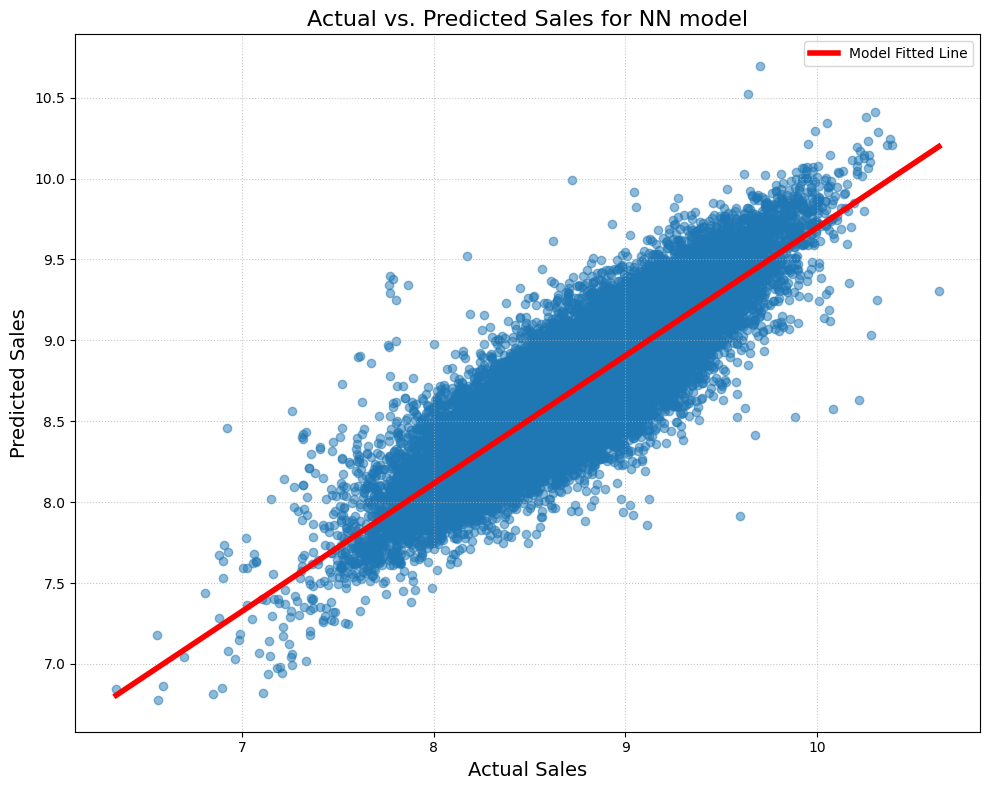

In [50]:
comparison_df = pd.DataFrame(
    {
        "Actual_Sales": y_test_original,
        "Predicted_Sales": y_pred_final_oiginal,
    }
)

plt.figure(figsize=(10, 8))

sns.regplot(
    x=y_test,
    y=y_predict_flat,
    scatter_kws={
        "alpha": 0.5,
    },
    line_kws={"color": "red", "label": "Model Fitted Line", "linewidth": 4},
)

plt.xlabel("Actual Sales", fontsize=14)
plt.ylabel("Predicted Sales", fontsize=14)
plt.title("Actual vs. Predicted Sales for NN model", fontsize=16)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

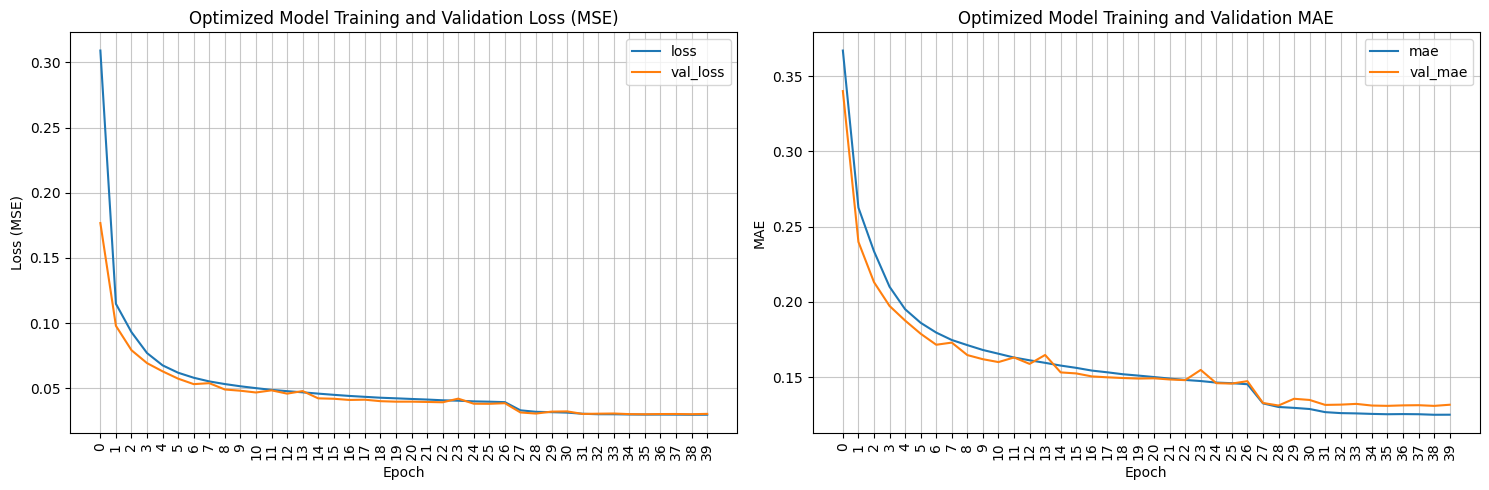

In [46]:
history_df = pd.DataFrame(history_final.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
history_df[["loss", "val_loss"]].plot(
    ax=axes[0],
    title="Optimized Model Training and Validation Loss (MSE)",
    xlabel="Epoch",
    ylabel="Loss (MSE)",
)
axes[0].grid(True, alpha = 0.7)
axes[0].set_xticks(history_df.index)
axes[0].tick_params(axis="x", rotation=90)

history_df[["mae", "val_mae"]].plot(
    ax=axes[1],
    title="Optimized Model Training and Validation MAE",
    xlabel="Epoch",
    ylabel="MAE",
)
axes[1].grid(True, alpha = 0.7)
axes[1].set_xticks(history_df.index)
axes[1].tick_params(axis="x", rotation=90)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

  59/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


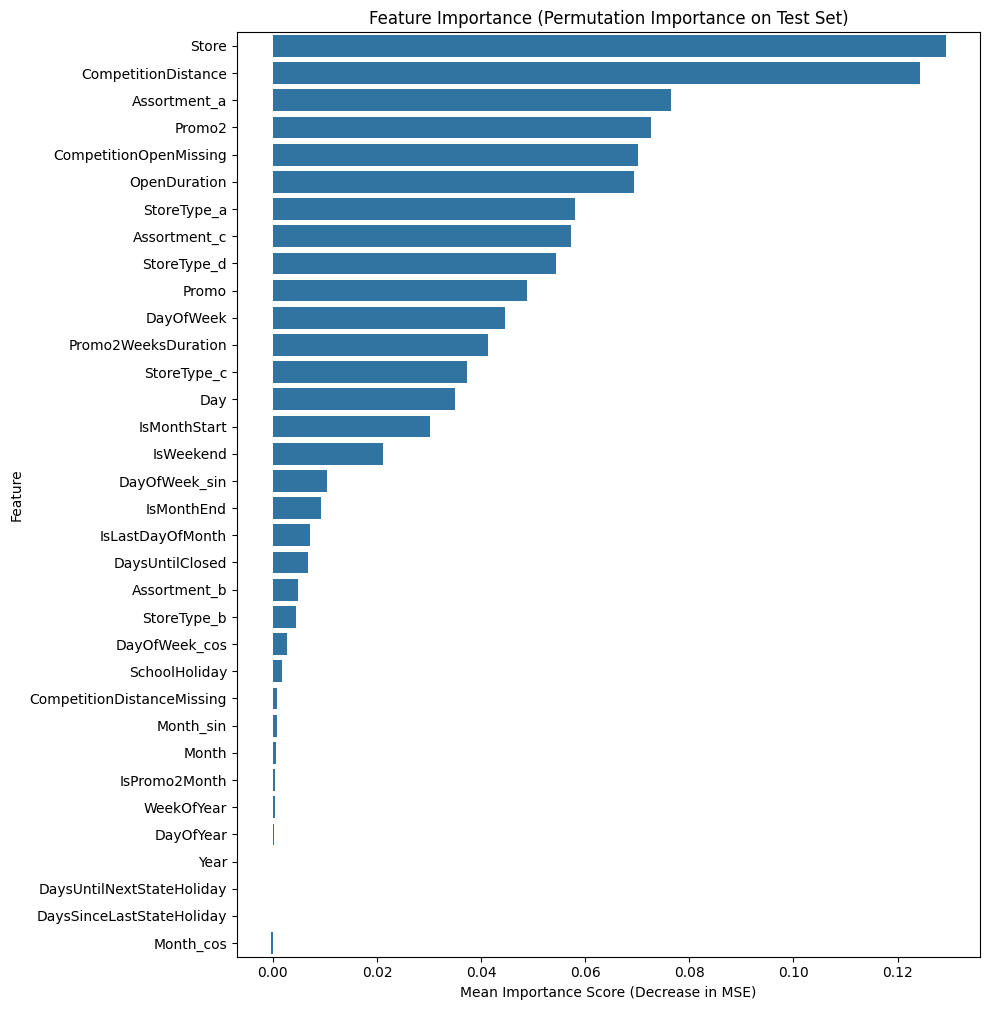

In [48]:
feature_names = preprocessor.get_feature_names_out()

r_perm = permutation_importance(
    estimator=best_model,
    X=X_test_scaled,
    y=y_test,
    scoring=lambda estimator, X, y: -mean_squared_error(
        y, estimator.predict(X).flatten()
    ),
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)

importance_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance_Mean": r_perm.importances_mean,
        "Importance_Std": r_perm.importances_std,
    }
).sort_values(by="Importance_Mean", ascending=False)

plt.figure(figsize=(10, len(importance_df) * 0.3))
sns.barplot(
    x="Importance_Mean",
    y="Feature",
    data=importance_df,
    capsize=0.2,
)
plt.title("Feature Importance (Permutation Importance on Test Set)")
plt.xlabel("Mean Importance Score (Decrease in MSE)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

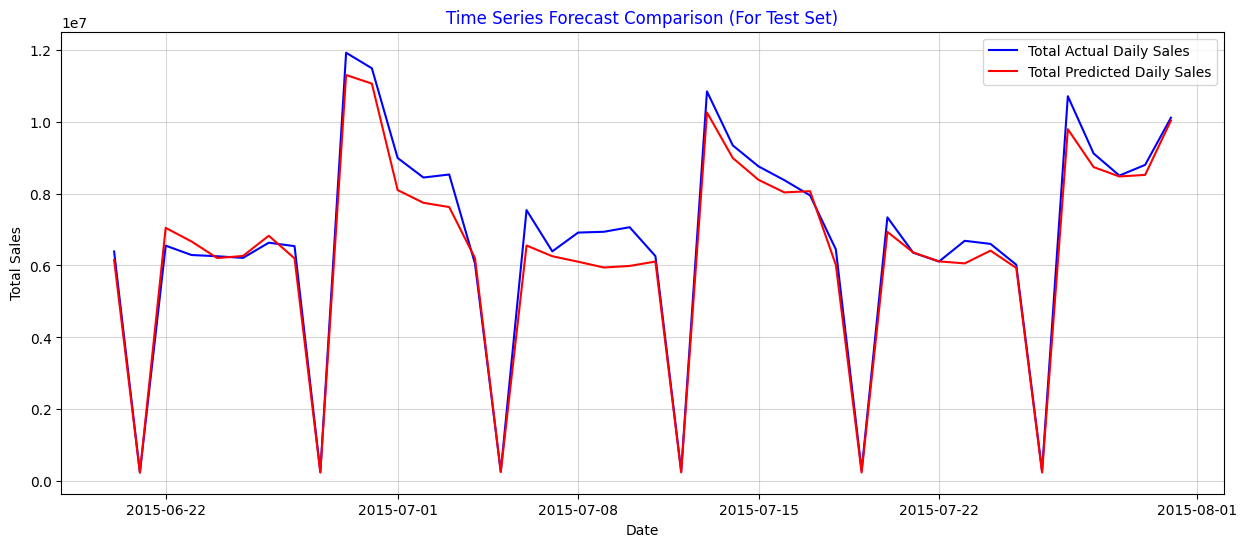

In [49]:
results_df = pd.DataFrame(
    {
        "Date": y_test_original.index,
        "Store": x_test.Store,
        "Actual_Sales": y_test_original,
        "Predicted_Sales": y_pred_final_oiginal,
    }
).set_index("Date")

df_aggregate = results_df.groupby(results_df.index).agg(
    {"Actual_Sales": "sum", "Predicted_Sales": "sum"}
)

plt.figure(figsize=(15, 6))

plt.plot(
    df_aggregate.index,
    df_aggregate["Actual_Sales"],
    label="Total Actual Daily Sales",
    color="blue",
)
plt.plot(
    df_aggregate.index,
    df_aggregate["Predicted_Sales"],
    label="Total Predicted Daily Sales",
    color="red",
)
plt.title("Time Series Forecast Comparison (For Test Set)", c="blue")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()